# Modeling Polar Ice Thickness from IceSat-2 Satellite Measurements
## Jeff Liu
#### Bayesian modeling of ice thickness given a satellite freeboard measurement with a hierarchical nonlinear multivariate truncated Gaussian model.
#### Posterior sampled using Metropolis-within-Gibbs Markov Chain Monte Carlo.

See the paper for full details of the model.

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, multivariate_normal, invgamma
from math import sqrt, exp
from sympy import Symbol
from sympy.solvers import solve

## Defining and calculating the prior and hyperprior

### Note on Constants

I got a (somewhat) arbitrary estimate of average snow depth of 0.15 meters from eyeballing the graphs on https://earthobservatory.nasa.gov/images/146758/mapping-snow-on-arctic-sea-ice.
I also borrowed average ice thickness of 2 meters from lecture, along with the lower/upper bounds given in the problem statement.

The variances I chose are wide to be less informative, but the bounds are truncated to prevent this from introducing inaccuracy.

### Hyperparameter Constants
I chose to use a very wide hyperprior since we have so little info. I reparametrized the inverse-gamma distributions in terms of mean and variance.
I chose a mean that was equal to the variance I expect by calculating the square of the standard deviation, and then choose the standard deviation to be equal to the mean.
That means that the variance will be the square of the mean, or the fourth power of the original parameter estimated standard deviation.

For the mean on the error variance hyperprior, I drew from Prof. Matthew Parno's suggestion that the IceSat-2 claims a standard error of 0.02 meters, and set the mean to the square of that.

For the mean on the snow variance hyperprior, I used the same estimate of 0.15 meters squared from the NASA sea ice website above.

In [57]:
# freeboard measurement
F = 0.1

# fixed variances
var_rw = 8**2
var_ri = 80**2
var_rs = 100**2
var_H = 2**2

# fixed means
mean_rw = 1020
mean_ri = 910
mean_rs = 300
mean_H = 2 # from lecture
mean_S = 0.15 # eyeballed estimate from NASA's CryoSat-2 website
mu_x = np.array([mean_rw, mean_ri, mean_rs, mean_H, mean_S]) # combined into one mean vector

# fixed upper and lower bounds on parameters
rw_lb = 1010
rw_ub = 1030
ri_lb = 750
ri_ub = 940
rs_lb = 100
rs_ub = 400
H_lb = 0.1 # from lecture
H_ub = 5 # from lecture
S_lb = 0 # we cannot have negative snow, no upper bound since limited info

# hyperparameter estimates
estimate_sigma_eps = 0.02 # from Dr. Parno's suggestion
estimate_sigma_S = mean_S # from CryoSat-2 website

# reparametrized hyper-hyper-parameters using hyperparameter estimates
mean_var_eps = estimate_sigma_eps**2
var_var_eps = mean_var_eps**2
mean_var_S = estimate_sigma_S**2
var_var_S = mean_var_S**2

### Calculating hyper-hyper-parameters $\alpha$ and $\beta$ using reparametrization on mean and variance (of variances)

In [25]:
def GetHyperHyperparams(mean, variance):
    alpha = Symbol('alpha')
    beta = Symbol('beta')
    
    # equations from wikipedia for inv-gamma parametrizations
    solution = solve([beta / (alpha-1) - mean, beta**2 / (alpha-1)**2 / (alpha-2) - variance])[0]
    return solution.values()

In [30]:
ae, be = GetHyperHyperparams(mean_var_eps, var_var_eps)
alpha_eps = float(ae)
beta_eps = float(be)
print('epsilon variance hyperhyperparams:', alpha_eps, beta_eps)

aS, bS = GetHyperHyperparams(mean_var_S, var_var_S)
alpha_S = float(aS)
beta_S = float(bS)
print('snow variance hyperhyperparams:', alpha_S, beta_S)

epsilon variance hyperhyperparams: 3.0 0.0008
snow variance hyperhyperparams: 3.0 0.045


# Visualizing the Prior

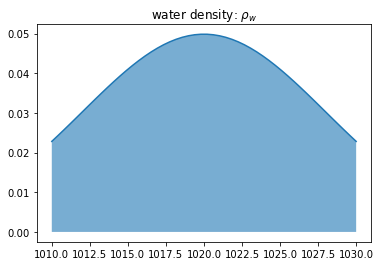

In [6]:
# seawater density
rws = np.linspace(rw_lb, rw_ub)
rws_pdf = norm.pdf(rws, mean_rw, sqrt(var_rw))
plt.plot(rws, rws_pdf)
plt.title('water density: $\\rho_w$')
plt.fill_between(rws, 0, rws_pdf, alpha=0.6)

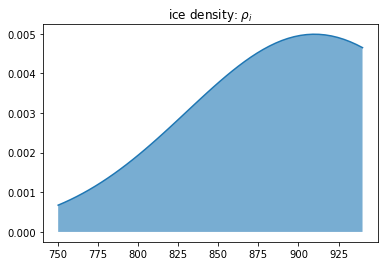

In [7]:
# ice density
ris = np.linspace(ri_lb, ri_ub)
ris_pdf = norm.pdf(ris, mean_ri, sqrt(var_ri))
plt.plot(ris, ris_pdf)
plt.title('ice density: $\\rho_i$')
plt.fill_between(ris, 0, ris_pdf, alpha=0.6)

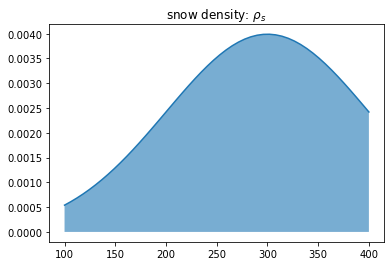

In [8]:
# snow density
rss = np.linspace(rs_lb, rs_ub)
rss_pdf = norm.pdf(rss, mean_rs, sqrt(var_rs))
plt.plot(rss, rss_pdf)
plt.title('snow density: $\\rho_s$')
plt.fill_between(rss, 0, rss_pdf, alpha=0.6)

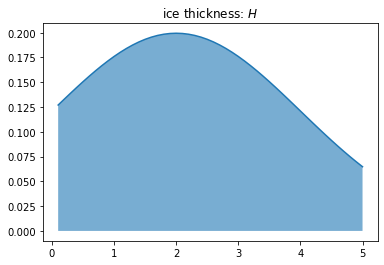

In [9]:
# Ice Thickness
Hs = np.linspace(H_lb, H_ub)
Hs_pdf = norm.pdf(Hs, mean_H, sqrt(var_H))
plt.plot(Hs, Hs_pdf)
plt.title('ice thickness: $H$')
plt.fill_between(Hs, 0, Hs_pdf, alpha=0.6)

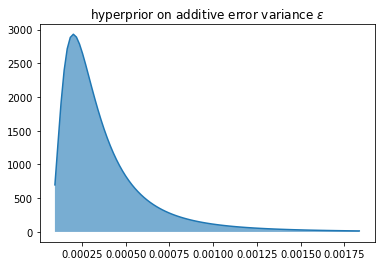

In [10]:
# error hyperprior
invgamma_eps = invgamma(alpha_eps, scale=beta_eps)
var_epss = np.linspace(invgamma_eps.ppf(0.01), invgamma_eps.ppf(0.99), 100)
var_epss_pdf = invgamma_eps.pdf(var_epss)
plt.plot(var_epss, var_epss_pdf)
plt.title('hyperprior on additive error variance $\\epsilon$')
plt.fill_between(var_epss, 0, var_epss_pdf, alpha=0.6)

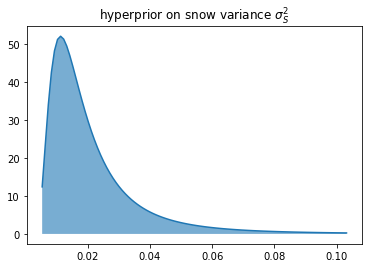

In [20]:
# snow hyperprior
invgamma_S = invgamma(alpha_S, scale=beta_S)
var_Ss = np.linspace(invgamma_S.ppf(0.01), invgamma_S.ppf(0.99), 100)
var_Ss_pdf = invgamma_S.pdf(var_Ss)
plt.plot(var_Ss, var_Ss_pdf)
plt.title('hyperprior on snow variance $\\sigma^2_S$')
plt.fill_between(var_Ss, 0, var_Ss_pdf, alpha=0.6)

# Defining the Model

### Forward Model
Computes the model's prediction of Freeboard given the three densities, snow thickness, and ice thickness.

In [31]:
def ForwardModel(rw, ri, rs, H, S):
    return (rw-ri)/rw * (H - S*(rs/(rw-ri))) # from problem statement

### Likelihood Function

Evaluate log of the likelihood of the freeboard measurement `F` given params `x` and some hierarchally modeled additive error `var_eps`:

$f(F | x, \epsilon) \sim N(0, \epsilon) $

where the value to evaluate the likelihood at is $F - g(x)$ where $g(x)$ is the forward model.

In [90]:
def LogLikelihood(x, F, var_eps):
    """
    ARGS:
        x (np.array): A numpy array of length 5 containing the model parameters: rw, ri, rs, H, S
        F (float): A scalar containing the observation of freeboard F
        var_eps (float): A scalar containing the given error variance
        
    RETURNS:
        (float): A scalar containing log( f(F | x, var_eps) )
    """
    if var_eps < 0:
        return -1e10 # big negative value, means log(zero) basically if out of bounds
    diff = F - ForwardModel(*x)
    sigma_eps = sqrt(var_eps)
    
    return norm.logpdf(diff, 0, sigma_eps)

### Bounds checking on prior

Since our prior consists of truncated normal distributions, we need to check if the proposed parameters `x` fit this.

In [14]:
def CheckPriorBounds(x):
    rw, ri, rs, H, S = x
    # uses global vars for lower/upper bounds
    return rw_lb <= rw <= rw_ub and ri_lb <= ri <= ri_ub and rs_lb <= rs <= rs_ub and H_lb <= H <= H_ub and S_lb <= S

### Prior Density of parameters

Evaluates log of the prior density of proposed parameters `x` given some variable snow variance:

$f(x|\sigma^2_S) \sim N(\mu_x, cov_x)$

where the covariance contains our snow variance, and where we evaluate the density with our proposed `x`.

Assume that the covariance matrix is diagonal; i.e. we have an independent prior.

In [91]:
def LogPrior(x, var_S):
    """
    ARGS:
        x (np.array): A numpy array of length 5 containing the model parameters: rw, ri, rs, H, S
        var_S (float): A scalar containing the snow variance
        
    RETURNS:
        (float): A scalar containing log( f(x | var_S) )
    """
    
    if not CheckPriorBounds(x) or var_S < 0:
        return -1e10 # big negative value, means log(zero) basically if out of bounds
    
    # the first four are global vars; var_S is a variable parameter
    cov_x = np.diag([var_rw, var_ri, var_rs, var_H, var_S])
    
    return multivariate_normal.logpdf(x, mean=mu_x, cov=cov_x)

### Inverse Gamma Hyperprior on variances
Evaluates the log of the inverse-gamma density on some variance and hyperparameters $\alpha$ and $\beta$.

In [32]:
def LogInvGamma(var, alpha, beta):
    return invgamma.logpdf(var, alpha, scale=beta)

### Posterior on parameters
Evaluates log of the posterior on model parameters `x`:

$f(x|F,\epsilon,\sigma^2_S) \propto f(F | x, \epsilon ) \cdot f(x|\sigma^2_S)$

which is the likelihood times the prior on `x`.

In [17]:
def LogPosteriorX(x, F, var_eps, var_S):
    """
    ARGS:
        x (np.array): A numpy array of length 5 containing the model parameters: rw, ri, rs, H, S
        F (float): A scalar containing the observation of freeboard F
        var_eps (float): A scalar containing the given error variance
        var_S (float): A scalar containing the snow variance
        
    RETURNS:
        (float): A scalar containing log( f(x | F, var_eps, var_S) )
    """
    return LogLikelihood(x, F, var_eps) + LogPrior(x, var_S)

### Posterior on error
Evaluates log of the posterior on the error `var_eps`:

$f(\epsilon | F, x) \propto f(F | x, \epsilon) f(\epsilon)$

evaluated at the proposed `var_eps`. All dependence on `var_S` is dropped since it's held constant here, and `x` is dropped in the final term since the error is independent of the parameters.

In [18]:
def LogPosteriorEps(x, F, var_eps):
    """
    ARGS:
        x (np.array): A numpy array of length 5 containing the model parameters: rw, ri, rs, H, S
        F (float): A scalar containing the observation of freeboard F
        var_eps (float): A scalar containing the given error variance
        
    RETURNS:
        (float): A scalar containing log( f(var_eps | F, x) )
    """
    # uses global variables for inv-gamma prior
    return LogLikelihood(x, F, var_eps) + LogInvGamma(var_eps, alpha_eps, beta_eps)

### Posterior on Snow Variance
Evaluates log of the posterior on the snow variance `var_S`:

$f(\sigma^2_S | F, x, \epsilon) = f(F | x, \epsilon) f(x | \sigma^2_S) f(\sigma^2_S)$

evaluated at a given `var_S`.

In [19]:
def LogPosteriorS(x, F, var_eps, var_S):
    """
    ARGS:
        x (np.array): A numpy array of length 5 containing the model parameters: rw, ri, rs, H, S
        F (float): A scalar containing the observation of freeboard F
        var_eps (float): A scalar containing the given error variance
        var_S (float): A scalar containing the snow variance
        
    RETURNS:
        (float): A scalar containing log( f(var_S | F, x, var_eps) )
    """
    # uses global variables for inv-gamma prior
    return LogLikelihood(x, F, var_eps) + LogPrior(x, var_S) + LogInvGamma(var_S, alpha_S, beta_S)

# Sampling the Posterior
Preparing for three-step Metropolis-Within-Gibbs sampling.

Repeat for each step on the Markov Chain:
1. Sample the posterior parameters
1. Sample the posterior error variance
1. Sample the posterior snow variance

Setup:
- Set up adjustable proposal distributions that take into account the scale of each parameter/hyperparameter for each of the three steps
- Define 3 functions for sampling the parameters and both sets of hyperparameters.

### Proposal distribution setup
Create a multivariate Gaussian proposal for `x` and univariate Gaussian proposals for each hyperparameter to take advantage of the benefits of symmetrical proposals.

Choose each proposal scale qualitatively based on the acceptance ratio and integrated autocorrelation time calculated after MCMC.

In [130]:
# proposal for x
x_prop_scale = 1.85e-3
x_prop_stds = x_prop_scale * np.sqrt(np.array([var_rw, var_ri, var_rs, var_H, mean_var_S])) # trying to move proportionally to the prior
print('x proposal standard deviations:', x_prop_stds)

# proposal for var_eps
eps_prop_scale = 1.85e-3
eps_prop_std = eps_prop_scale * estimate_sigma_eps
print('var_eps proposal std dev:', eps_prop_std)

# proposal for var_S
S_prop_scale = 1.85e-3
S_prop_std = S_prop_scale * estimate_sigma_S
print('var_S proposal std dev:', S_prop_std)

x proposal standard deviations: [0.0148    0.148     0.185     0.0037    0.0002775]
var_eps proposal std dev: 3.7000000000000005e-05
var_S proposal std dev: 0.0002775


### Sampling the posterior parameters `x` given fixed hyperparameters using `LogPosteriorX` function

In [49]:
def SampleX(x, F, var_eps, var_S, past_logPosterior):
    """
    ARGS:
        x (np.array): A numpy array of length 5 containing the model parameters: rw, ri, rs, H, S
        F (float): A scalar containing the observation of freeboard F
        var_eps (float): A scalar containing the given error variance
        var_S (float): A scalar containing the snow variance
        past_logPosterior(float): A scalar containing the log-posterior on x (for use in acceptance ratio/returning)
        
    RETURNS:
        (boolean): true if the new proposal was accepted, false otherwise
        (np.array): A numpy array containing the next x (which may be old or new)
        (float): the log-posterior of that x
    """
    # uses global variable x_prop_stds for standard deviations
    proposal_x = x + x_prop_stds * np.random.randn(5) # 5 is number of params in x
    proposal_logPosterior = LogPosteriorX(x, F, var_eps, var_S)
    
    # acceptance ratio
    gamma = exp(proposal_logPosterior - past_logPosterior)
    
    # accept or reject
    p = np.random.rand()
    if p < gamma:
        return True, proposal_x, proposal_logPosterior
    else:
        return False, x, past_logPosterior

### Sampling the posterior hyperparameter `var_eps` given fixed `x` using `LogPosteriorEps`

In [50]:
def SampleEps(x, F, var_eps, past_logPosterior):
    """
    ARGS:
        x (np.array): A numpy array of length 5 containing the model parameters: rw, ri, rs, H, S
        F (float): A scalar containing the observation of freeboard F
        var_eps (float): A scalar containing the given error variance
        past_logPosterior(float): A scalar containing the log-posterior on var_eps (for use in acceptance ratio/returning)
        
    RETURNS:
        (boolean): true if the new proposal was accepted, false otherwise
        (float): the next var_eps (which may be old or new)
        (float): the log-posterior of that var_eps
    """
    # uses global var eps_prop_std for std dev
    proposal_var_eps = norm.rvs(var_eps, eps_prop_std)
    proposal_logPosterior = LogPosteriorEps(x, F, var_eps)
    
    # acceptance ratio
    gamma = exp(proposal_logPosterior - past_logPosterior)
    
    # accept or reject
    p = np.random.rand()
    if p < gamma:
        return True, proposal_var_eps, proposal_logPosterior
    else:
        return False, var_eps, past_logPosterior

### Sampling the posterior hyperparameter `var_eps` given fixed `x` using `LogPosteriorEps`

In [51]:
def SampleS(x, F, var_eps, var_S, past_logPosterior):
    """
    ARGS:
        x (np.array): A numpy array of length 5 containing the model parameters: rw, ri, rs, H, S
        F (float): A scalar containing the observation of freeboard F
        var_eps (float): A scalar containing the given error variance
        var_S (float): A scalar containing the snow variance
        past_logPosterior(float): A scalar containing the log-posterior on var_S (for use in acceptance ratio/returning)
        
    RETURNS:
        (boolean): true if the new proposal was accepted, false otherwise
        (float): the next var_S (which may be old or new)
        (float): the log-posterior of that var_S
    """
    # uses global var S_prop_std for std dev
    proposal_var_S = norm.rvs(var_S, S_prop_std)
    proposal_logPosterior = LogPosteriorS(x, F, var_eps, var_S)
    
    # acceptance ratio
    gamma = exp(proposal_logPosterior - past_logPosterior)
    
    # accept or reject
    p = np.random.rand()
    if p < gamma:
        return True, proposal_var_S, proposal_logPosterior
    else:
        return False, var_S, past_logPosterior

## Markov Chain Monte Carlo

Set up some numpy matrices to record samples, then run the sampling forward, keeping track of the acceptance ratio for each type of step in Gibbs sampling.

In [135]:
num_steps = 2000

# start at mean of prior and hyperpriors since why not
x0 = mu_x
var_eps0 = mean_var_eps
var_S0 = mean_var_S

# recording of the samples and accept ratio
samps_x = np.zeros((num_steps, 5))
logposts_x = np.zeros((num_steps))
accepts_x = 0

samps_var_eps = np.zeros((num_steps))
logposts_var_eps = np.zeros((num_steps))
accepts_var_eps = 0

samps_var_S = np.zeros((num_steps))
logposts_var_S = np.zeros((num_steps))
accepts_var_S = 0

# insert initial conditions into the arrays
samps_x[0,:] = x0
logposts_x[0] = LogPosteriorX(x0, F, var_eps0, var_S0)

samps_var_eps[0] = var_eps0
logposts_var_eps[0] = LogPosteriorEps(x0, F, var_eps0)

samps_var_S[0] = var_S0
logposts_var_S[0] = LogPosteriorS(x0, F, var_eps0, var_S0)

In [136]:
# run the markov chain

for i in range(num_steps - 1):
    # get some info from the prior step
    past_x = samps_x[i, :]
    past_logpost_x = logposts_x[i]
    past_var_eps = samps_var_eps[i]
    past_var_S = samps_var_S[i]
    
    # sample x
    x_accept, next_x, next_logpost_x = SampleX(past_x, F, past_var_eps, past_var_S, past_logpost_x)
    
    # update the chain with new info
    if x_accept:
        accepts_x += 1
    samps_x[i+1, :] = next_x
    logposts_x[i+1] = next_logpost_x
    
    # retrieve more information
    past_logpost_var_eps = logposts_var_eps[i]
    past_x = next_x # advance the x increment early to maybe reduce IACT
    
    # sample var_eps
    var_eps_accept, next_var_eps, next_logpost_var_eps = SampleEps(past_x, F, past_var_eps, past_logpost_var_eps)
    
    # update the chain
    if var_eps_accept:
        accepts_var_eps += 1
    samps_var_eps[i+1] = next_var_eps
    logposts_var_eps[i+1] = next_logpost_var_eps
    
    # retrieve more info
    past_logpost_var_S = logposts_var_S[i]
    past_var_eps = next_var_eps # advance the var_eps increment early to maybe reduce IACT
    
    # sample var_S
    var_S_accept, next_var_S, next_logpost_var_S = SampleS(past_x, F, past_var_eps, past_var_S, past_logpost_var_S)
    
    # update the chain
    if var_S_accept:
        accepts_var_S += 1
    samps_var_S[i+1] = next_var_S
    logposts_var_S[i+1] = next_logpost_var_S
    
    if i % 100 == 0 and i > 0:
        print('Step %d, x AR = %0.2f, var_eps AR = %0.2f, var_S AR = %0.2f'%(i, accepts_x/(i+1), accepts_var_eps/(i+1), accepts_var_S/(i+1)) )

Step 100, x AR = 0.21, var_eps AR = 0.57, var_S AR = 0.54
Step 200, x AR = 0.53, var_eps AR = 0.33, var_S AR = 0.27
Step 300, x AR = 0.56, var_eps AR = 0.42, var_S AR = 0.36
Step 400, x AR = 0.60, var_eps AR = 0.43, var_S AR = 0.40
Step 500, x AR = 0.59, var_eps AR = 0.45, var_S AR = 0.43
Step 600, x AR = 0.52, var_eps AR = 0.37, var_S AR = 0.35
Step 700, x AR = 0.54, var_eps AR = 0.35, var_S AR = 0.32
Step 800, x AR = 0.57, var_eps AR = 0.37, var_S AR = 0.35
Step 900, x AR = 0.50, var_eps AR = 0.34, var_S AR = 0.32
Step 1000, x AR = 0.45, var_eps AR = 0.31, var_S AR = 0.28
Step 1100, x AR = 0.42, var_eps AR = 0.29, var_S AR = 0.26
Step 1200, x AR = 0.39, var_eps AR = 0.27, var_S AR = 0.24
Step 1300, x AR = 0.36, var_eps AR = 0.25, var_S AR = 0.23
Step 1400, x AR = 0.34, var_eps AR = 0.23, var_S AR = 0.21
Step 1500, x AR = 0.32, var_eps AR = 0.22, var_S AR = 0.20
Step 1600, x AR = 0.30, var_eps AR = 0.20, var_S AR = 0.18
Step 1700, x AR = 0.28, var_eps AR = 0.19, var_S AR = 0.17
Step 1

# Plot the Posterior Samples

## Trace Plots

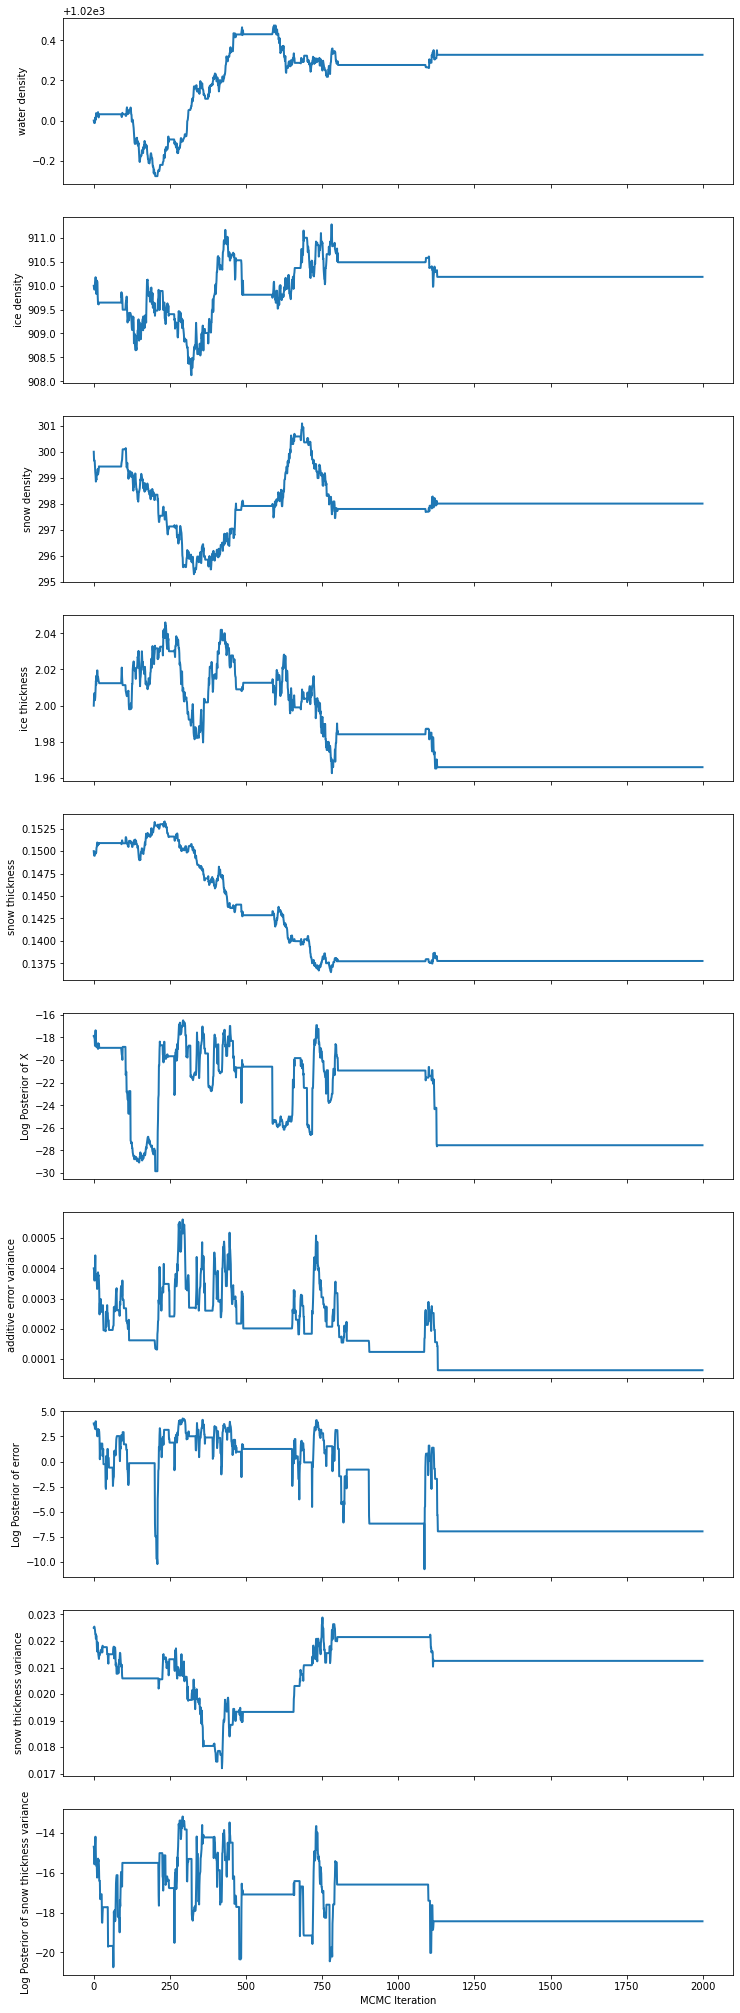

In [141]:
fig, axs = plt.subplots(nrows=10,sharex=True, figsize=(12,36))
axs[0].plot(samps_x[:, 0], linewidth=2)
axs[0].set_ylabel('water density')

axs[1].plot(samps_x[:, 1], linewidth=2)
axs[1].set_ylabel('ice density')

axs[2].plot(samps_x[:, 2], linewidth=2)
axs[2].set_ylabel('snow density')

axs[3].plot(samps_x[:, 3], linewidth=2)
axs[3].set_ylabel('ice thickness')

axs[4].plot(samps_x[:, 4], linewidth=2)
axs[4].set_ylabel('snow thickness')

axs[5].plot(logposts_x, linewidth=2)
axs[5].set_ylabel('Log Posterior of X')

axs[6].plot(samps_var_eps, linewidth=2)
axs[6].set_ylabel('additive error variance')

axs[7].plot(logposts_var_eps, linewidth=2)
axs[7].set_ylabel('Log Posterior of error')

axs[8].plot(samps_var_S, linewidth=2)
axs[8].set_ylabel('snow thickness variance')

axs[9].plot(logposts_var_S, linewidth=2)
axs[9].set_ylabel('Log Posterior of snow thickness variance')

axs[9].set_xlabel('MCMC Iteration')

plt.show()